In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
from regionate import MaskRegions
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

# Conservatively diagnosing model transports across arbitrary sections with `sectionate`

## Load example model grid and transport diagnosics

In [3]:
from example_dataset_grids import load_CM4p25
grid = load_CM4p25(z_coord="rho2")
ds = grid._ds

## Diagnosing Meridional Overturning Streamfunctions

In [4]:
import xoverturning

#### Density vs. Nominal Latitude

In [5]:
ds_rho2 = grid._ds.isel(yq=slice(1,None),xq=slice(1,None))
with ProgressBar():
    moc_nominal = xoverturning.calcmoc(ds_rho2, dsgrid=ds_rho2, vertical='rho2').compute()

generating basin codes
[########################################] | 100% Completed | 18.79 ss


(1038.0, 1028.0)

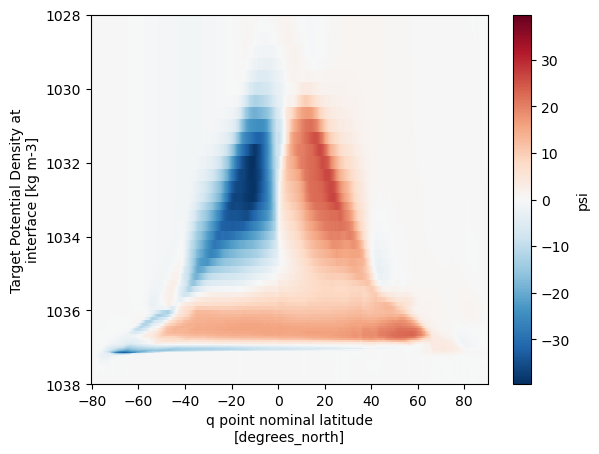

In [17]:
moc_nominal.mean('time').plot(x="yq")
plt.ylim(1038, 1028)

#### Density vs. Latitude

In [6]:
names_rho2 = {'x_center': 'sect',
              'layer': 'rho2_l',
              'interface': 'rho2_i'}

In [20]:
def transport_across_latitude_line(grid, lat):
    mask = grid._ds['geolat'] < lat
    region = MaskRegions(mask, grid).regions[0]
    conv_transport = sectionate.convergent_transport(grid, region.i, region.j, layer="rho2_l", interface="rho2_i")
    northward_transport = -xoverturning.compfunc.compute_streamfunction(conv_transport, names_rho2, transport='conv_mass_transport')
    
    return northward_transport.expand_dims({'lat': xr.DataArray([lat], dims=('lat',))})

def global_moc(grid, dlat=1.):
    return xr.concat([transport_across_latitude_line(grid, lat) for lat in np.arange(-76, 90., dlat)], dim="lat")

In [24]:
with ProgressBar():
    moc = global_moc(grid, dlat=0.5).compute()

[########################################] | 100% Completed | 70.30 s


(1038.0, 1028.0)

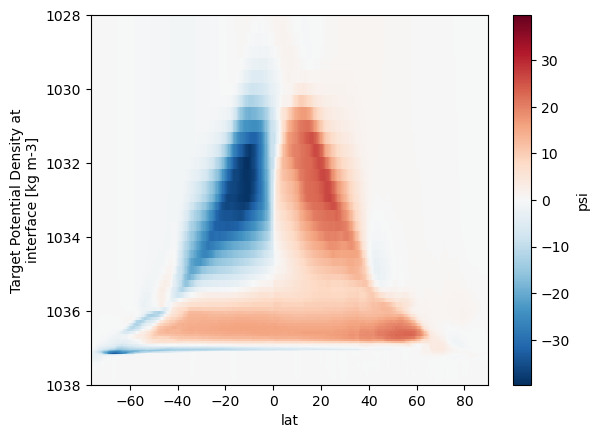

In [25]:
moc.mean('time').plot(x="lat")
plt.ylim(1038, 1028)

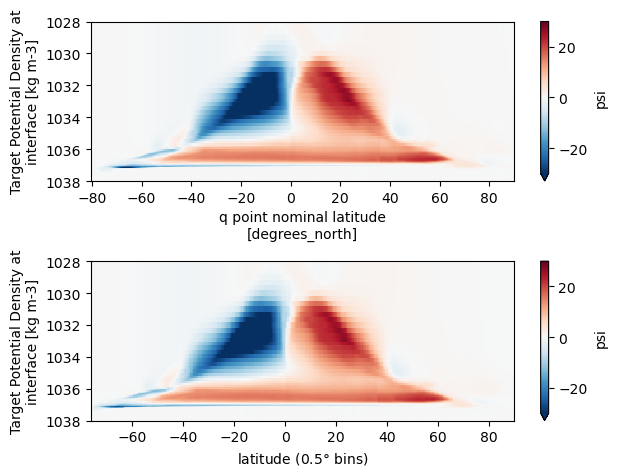

In [31]:
plt.subplot(2,1,1)
moc_nominal.mean('time').plot(x="yq", vmin=-30, vmax=30., cmap="RdBu_r")
plt.ylim(1038, 1028)

plt.subplot(2,1,2)
moc.mean('time').plot(x="lat", vmin=-30, vmax=30., cmap="RdBu_r")
plt.ylim(1038, 1028)
plt.xlabel(r"latitude (0.5$\degree$ bins)")
plt.tight_layout()

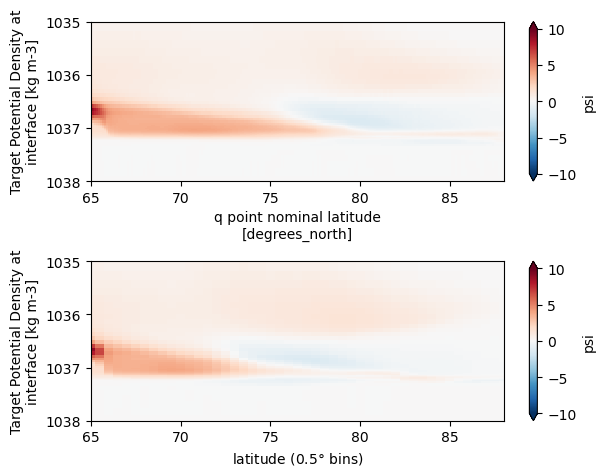

In [44]:
plt.subplot(2,1,1)
moc_nominal.mean('time').plot(x="yq", vmin=-10, vmax=10., cmap="RdBu_r")
plt.ylim(1038, 1035)
plt.xlim(65, 88)

plt.subplot(2,1,2)
moc.mean('time').plot(x="lat", vmin=-10, vmax=10., cmap="RdBu_r")
plt.ylim(1038, 1035)
plt.xlim(65, 88)
plt.xlabel(r"latitude (0.5$\degree$ bins)");
plt.tight_layout()

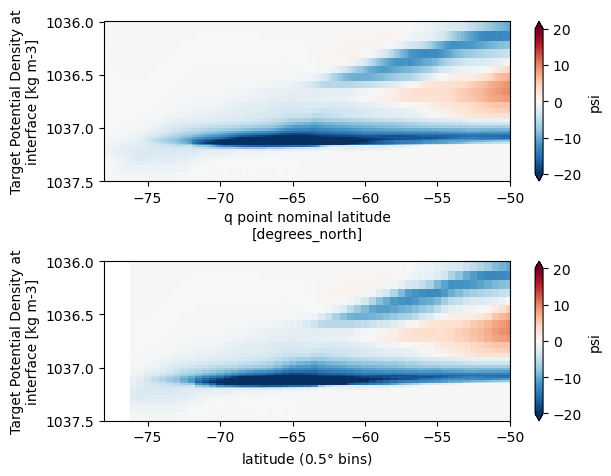

In [48]:
plt.subplot(2,1,1)
moc_nominal.mean('time').plot(x="yq", vmin=-20, vmax=20., cmap="RdBu_r")
plt.ylim(1037.5, 1036)
plt.xlim(-78, -50)

plt.subplot(2,1,2)
moc.mean('time').plot(x="lat", vmin=-20, vmax=20., cmap="RdBu_r")
plt.ylim(1037.5, 1036)
plt.xlim(-78, -50)
plt.xlabel(r"latitude (0.5$\degree$ bins)");
plt.tight_layout()